# Computer Vision for Image Analytics
# Image Classification using Pre-Trained models

# Check the tensorflow GPU and torch GPU

In [9]:
import pandas as pd
import tensorflow as tf
print(len(tf.config.list_physical_devices('GPU')))
import torch
print(torch.cuda.is_available())

1

True


# Import important libraries

In [10]:

import tensorflow as tf
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Activation, Dropout, BatchNormalization
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
from skimage import transform

In [11]:
photo_size=200

# Prepare dataset and add some augmentation

In [12]:
def prepare_dataset(data_dir):
    datagen = ImageDataGenerator(
        rescale=1 / 255,
        rotation_range=40,
        width_shift_range=.2,
        height_shift_range=.2,
        shear_range=.1,
        horizontal_flip=True,
        fill_mode='nearest',
        zoom_range=.2,
    )
    generator = datagen.flow_from_directory(
        data_dir,
        target_size=(photo_size,photo_size),
        class_mode='binary',
        batch_size=128,
        # classes=[str(i) for i in range(2)]
    )
    return generator

In [13]:
import zipfile
zip_df = zipfile.ZipFile("/kaggle/input/dogs-vs-cats-redux-kernels-edition/train.zip", 'r')
zip_df.extractall("/kaggle/working/")
zip_df.close()

# Spliting Dogs and Cats in the training file to determine the classes

In [14]:
import os
from shutil import copyfile,move
file_path = "./train/"
os.mkdir(os.path.join(file_path, 'Cats'))
os.mkdir(os.path.join(file_path, 'Dogs'))
for i,image_name in enumerate(os.listdir(file_path)):
    if 'cat'in image_name :
        move(os.path.join(file_path, image_name),os.path.join(os.path.join(file_path, 'Cats'),image_name))

for i,image_name in enumerate(os.listdir(file_path)):
    if 'dog'in image_name :
        move(os.path.join(file_path, image_name),os.path.join(os.path.join(file_path, 'Dogs'),image_name))


# Create validation directory

In [15]:
os.mkdir(os.path.join('./', 'validation'))


# Split training ,validation and  testing Dataset

In [16]:
import shutil
import os
import numpy as np
import argparse

def get_files_from_folder(path):
    files = os.listdir(path)
    return np.asarray(files)

def image_train_test_split(path_to_data, path_to_test_data, train_ratio):
    # get dirs
    _, dirs, _ = next(os.walk(path_to_data))

    # calculates how many train data per class
    data_counter_per_class = np.zeros((len(dirs)))
    for i in range(len(dirs)):
        path = os.path.join(path_to_data, dirs[i])
        files = get_files_from_folder(path)
        data_counter_per_class[i] = len(files)
    test_counter = np.round(data_counter_per_class * (1 - train_ratio))

    # transfers files
    for i in range(len(dirs)):
        path_to_original = os.path.join(path_to_data, dirs[i])
        path_to_save = os.path.join(path_to_test_data, dirs[i])

        #creates dir
        if not os.path.exists(path_to_save):
            os.makedirs(path_to_save)
        files = get_files_from_folder(path_to_original)
        # moves data
        for j in range(int(test_counter[i])):
            dst = os.path.join(path_to_save, files[j])
            src = os.path.join(path_to_original, files[j])
            shutil.move(src, dst)



In [17]:
image_train_test_split('./train/', './validation/', float(0.9))

# Load Dataset from directory

In [18]:
train_data=prepare_dataset('./train/')
validation_data = prepare_dataset('./validation/')



Found 22500 images belonging to 2 classes.

Found 2500 images belonging to 2 classes.


# Unzip test data

In [19]:
import zipfile
zip_df = zipfile.ZipFile("/kaggle/input/dogs-vs-cats-redux-kernels-edition/test.zip", 'r')
zip_df.extractall("/kaggle/working/")
zip_df.close()

In [20]:
validation_data.class_indices

{'Cats': 0, 'Dogs': 1}

# Load pre-trained models

## Basic Vgg model

In [15]:
# example of tending the vgg16 model
def create_vgg_model():
    from keras.applications.vgg16 import VGG16
    from keras.models import Model
    from keras.layers import Dense
    from keras.layers import Flatten
    # load model without classifier layers
    model = VGG16(include_top=False, input_shape=(photo_size, photo_size, 3))
    for layer_idx in range(len(model.layers)):
        if layer_idx not in [1,2,3,15,16,17,18]:
            model.layers[layer_idx].trainable = False
    # add new classifier layers
    flat1 = Flatten()(model.layers[-1].output)
    class1 = Dense(128, activation='relu')(flat1)
    # class1 = Dense(256, activation='relu')(class1)
    output = Dense(1, activation='sigmoid')(class1)
    # define new model
    model = Model(inputs=model.inputs, outputs=output)
    return model

In [16]:
vgg_model=create_vgg_model()
vgg_model.summary()


58889256/58889256 [==============================] - 0s 0us/step

Model: "model"

_________________________________________________________________

 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 200, 200, 3)]     0         

                                                                 

 block1_conv1 (Conv2D)       (None, 200, 200, 64)      1792      

                                                                 

 block1_conv2 (Conv2D)       (None, 200, 200, 64)      36928     

                                                                 

 block1_pool (MaxPooling2D)  (None, 100, 100, 64)      0         

                                                                 

 block2_conv1 (Conv2D)       (None, 100, 100, 128)     73856     

                                                                 

 block2_conv2 (Conv2D)       (None, 100, 100, 128)     147584    

                                             

In [17]:
vgg_model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
vgg_model.fit(
    train_data,
    epochs=5,
    validation_data=validation_data
)
vgg_model.save("Dogs_vs_cats_vgg_model30.h5")

Epoch 1/5

176/176 [==============================] - 316s 2s/step - loss: 0.7858 - accuracy: 0.5118 - val_loss: 0.6901 - val_accuracy: 0.5244

Epoch 2/5

176/176 [==============================] - 284s 2s/step - loss: 0.6845 - accuracy: 0.5576 - val_loss: 0.6331 - val_accuracy: 0.6476

Epoch 3/5

176/176 [==============================] - 284s 2s/step - loss: 0.6008 - accuracy: 0.6761 - val_loss: 0.5152 - val_accuracy: 0.7456

Epoch 4/5

176/176 [==============================] - 282s 2s/step - loss: 0.4261 - accuracy: 0.8047 - val_loss: 0.2785 - val_accuracy: 0.8812

Epoch 5/5

176/176 [==============================] - 282s 2s/step - loss: 0.2481 - accuracy: 0.8975 - val_loss: 0.2038 - val_accuracy: 0.9272


# VGG After Fine Tuning

In [19]:
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.layers import Dense, Flatten, Dropout
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator

def create_fine_tuned_vgg_model(photo_size, learning_rate):
    base_model = VGG16(include_top=False, input_shape=(photo_size, photo_size, 3))
    for layer in base_model.layers:
        layer.trainable = False

    x = Flatten()(base_model.output)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)  # Adding dropout for regularization
    output = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=base_model.input, outputs=output)

    model.compile(optimizer=Adam(learning_rate),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model

# Data augmentation parameters
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(rescale=1.0 / 255)

# Set up data generators
train_generator = train_datagen.flow_from_directory(
    './train/',  # Specify your training data directory
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

validation_generator = validation_datagen.flow_from_directory(
    './validation/',  # Specify your validation data directory
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

model = create_fine_tuned_vgg_model(photo_size=224, learning_rate=0.001)

model.fit(train_generator, epochs=5, validation_data=validation_generator)
model.save("Dogs_vs_cats_VGG_mode.h5")

704/704 [==============================] - 334s 470ms/step - loss: 0.4826 - accuracy: 0.7703 - val_loss: 0.2990 - val_accuracy: 0.8776

Epoch 2/5

704/704 [==============================] - 330s 469ms/step - loss: 0.4007 - accuracy: 0.8176 - val_loss: 0.2805 - val_accuracy: 0.8828

Epoch 3/5

704/704 [==============================] - 332s 471ms/step - loss: 0.3840 - accuracy: 0.8221 - val_loss: 0.2564 - val_accuracy: 0.8972

Epoch 4/5

704/704 [==============================] - 331s 469ms/step - loss: 0.3938 - accuracy: 0.8121 - val_loss: 0.2677 - val_accuracy: 0.8852

Epoch 5/5

704/704 [==============================] - 334s 474ms/step - loss: 0.3729 - accuracy: 0.8306 - val_loss: 0.2472 - val_accuracy: 0.9020


## Basic ResNet50

In [22]:
from tensorflow.keras.applications import ResNet50
#from keras.applications.resnet50 import ResNet50
from keras.models import Model
from keras.layers import Dense, Flatten

# Create a ResNet50 model with modified classifier layers
def create_resnet_model():
    # Load ResNet50 model without classifier layers
    model = ResNet50(weights='imagenet', include_top=False, input_shape=(photo_size, photo_size, 3))

    
    # Freeze layers except for specific ones
    for layer_idx in range(len(model.layers)):
        if layer_idx not in [81, 82, 83, 91, 92, 93, 94]:  # Choose the appropriate layers
            model.layers[layer_idx].trainable = False
    
    # Add new classifier layers
    flat1 = Flatten()(model.layers[-1].output)
    class1 = Dense(128, activation='relu')(flat1)
    # class1 = Dense(256, activation='relu')(class1)
    output = Dense(1, activation='sigmoid')(class1)
    
    # Define the new model
    model = Model(inputs=model.inputs, outputs=output)
    return model

In [23]:
resnet_model = create_resnet_model()
resnet_model.summary()


94765736/94765736 [==============================] - 0s 0us/step

Model: "model_3"

__________________________________________________________________________________________________

 Layer (type)                   Output Shape         Param #     Connected to                     


 input_4 (InputLayer)           [(None, 200, 200, 3  0           []                               

                                )]                                                                

                                                                                                  

 conv1_pad (ZeroPadding2D)      (None, 206, 206, 3)  0           ['input_4[0][0]']                

                                                                                                  

 conv1_conv (Conv2D)            (None, 100, 100, 64  9472        ['conv1_pad[0][0]']              

                                )                                                                 

              

In [24]:
resnet_model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
resnet_model.fit(
    train_data,
    epochs=5,
    validation_data=validation_data
)
resnet_model.save("Dogs_vs_cats_resnet_model31.h5")

Epoch 1/5

176/176 [==============================] - 323s 2s/step - loss: 1.0089 - accuracy: 0.5862 - val_loss: 0.6640 - val_accuracy: 0.5908

Epoch 2/5

176/176 [==============================] - 310s 2s/step - loss: 0.6309 - accuracy: 0.6475 - val_loss: 0.6423 - val_accuracy: 0.6384

Epoch 3/5

176/176 [==============================] - 312s 2s/step - loss: 0.6092 - accuracy: 0.6661 - val_loss: 0.6015 - val_accuracy: 0.6796

Epoch 4/5

176/176 [==============================] - 315s 2s/step - loss: 0.5772 - accuracy: 0.7004 - val_loss: 0.6009 - val_accuracy: 0.6672

Epoch 5/5

176/176 [==============================] - 311s 2s/step - loss: 0.5567 - accuracy: 0.7149 - val_loss: 0.5802 - val_accuracy: 0.6952


# ResNet50 After Fine Tuning

In [27]:
from tensorflow.keras.applications import ResNet50
#from keras.applications.resnet50 import ResNet50
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator

def create_fine_tuned_resnet_model(photo_size, learning_rate):
    base_model = ResNet50(include_top=False, input_shape=(photo_size, photo_size, 3))
    for layer in base_model.layers:
        layer.trainable = False

    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)  # Adding dropout for regularization
    output = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=base_model.input, outputs=output)

    model.compile(optimizer=Adam(learning_rate),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model

# Data augmentation parameters
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(rescale=1.0 / 255)

# Set up data generators
train_generator = train_datagen.flow_from_directory(
    './train/',  # Specify your training data directory
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

validation_generator = validation_datagen.flow_from_directory(
    './validation/',  # Specify your validation data directory
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

model = create_fine_tuned_resnet_model(photo_size=224, learning_rate=0.001)

model.fit(train_generator, epochs=5, validation_data=validation_generator)
model.save("Dogs_vs_cats_renet_mode.h5")

Found 22500 images belonging to 2 classes.

Found 2500 images belonging to 2 classes.

Epoch 1/5

704/704 [==============================] - 334s 468ms/step - loss: 0.6872 - accuracy: 0.5488 - val_loss: 0.6691 - val_accuracy: 0.6092

Epoch 2/5

704/704 [==============================] - 333s 473ms/step - loss: 0.6785 - accuracy: 0.5735 - val_loss: 0.6628 - val_accuracy: 0.6180

Epoch 3/5

704/704 [==============================] - 333s 473ms/step - loss: 0.6772 - accuracy: 0.5744 - val_loss: 0.6601 - val_accuracy: 0.6196

Epoch 4/5

704/704 [==============================] - 330s 469ms/step - loss: 0.6749 - accuracy: 0.5720 - val_loss: 0.6586 - val_accuracy: 0.6276

Epoch 5/5

704/704 [==============================] - 329s 467ms/step - loss: 0.6737 - accuracy: 0.5785 - val_loss: 0.6533 - val_accuracy: 0.6224


# Basic AlexNet

In [28]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

num_classes = 2  # Number of classes for binary classification

def create_alexnet_model(include_top=False, input_shape=(photo_size, photo_size, 3)):
    model = Sequential([
        Conv2D(96, (11, 11), strides=(4, 4), activation='relu', input_shape=input_shape),
        MaxPooling2D((3, 3), strides=(2, 2)),
        Conv2D(256, (5, 5), activation='relu'),
        MaxPooling2D((3, 3), strides=(2, 2)),
        Conv2D(384, (3, 3), activation='relu'),
        Conv2D(384, (3, 3), activation='relu'),
        Conv2D(256, (3, 3), activation='relu'),
        MaxPooling2D((3, 3), strides=(2, 2)),
        Flatten(),
        Dense(4096, activation='relu'),
        Dense(4096, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    return model

In [29]:
alexnet_model = create_alexnet_model()
alexnet_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [30]:
alexnet_model.fit(
    train_data,  # Your training data here
    epochs=5,
    validation_data=validation_data,
    steps_per_epoch=5
)

Epoch 1/5

5/5 [==============================] - 44s 9s/step - loss: 0.8614 - accuracy: 0.5047 - val_loss: 0.6934 - val_accuracy: 0.5020

Epoch 2/5

5/5 [==============================] - 39s 9s/step - loss: 0.7073 - accuracy: 0.5172 - val_loss: 0.7044 - val_accuracy: 0.5000

Epoch 3/5

5/5 [==============================] - 38s 9s/step - loss: 0.7031 - accuracy: 0.4875 - val_loss: 0.6942 - val_accuracy: 0.5000

Epoch 4/5

5/5 [==============================] - 38s 9s/step - loss: 0.6950 - accuracy: 0.4703 - val_loss: 0.6931 - val_accuracy: 0.4936

Epoch 5/5

5/5 [==============================] - 38s 9s/step - loss: 0.6941 - accuracy: 0.5180 - val_loss: 0.6943 - val_accuracy: 0.5000


# AlexNet after fine tuning

**Please note that Keras doesn't provide a pre-built AlexNet model like it does for VGG16 or ResNet. You'll need to implement AlexNet architecture manually using Keras layers. Here's an example code using the AlexNet architecture and data augmentation:**

In [31]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator

def create_alexnet_model(photo_size, learning_rate):
    model = Sequential()

    # Convolutional and Pooling Layers
    model.add(Conv2D(96, (11, 11), strides=(4, 4), activation='relu', input_shape=(photo_size, photo_size, 3)))
    model.add(MaxPooling2D((3, 3), strides=(2, 2)))
    model.add(Conv2D(256, (5, 5), padding='same', activation='relu'))
    model.add(MaxPooling2D((3, 3), strides=(2, 2)))
    model.add(Conv2D(384, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(384, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D((3, 3), strides=(2, 2)))

    # Fully Connected Layers
    model.add(Flatten())
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer=Adam(learning_rate),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model

# Data augmentation parameters
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(rescale=1.0 / 255)

# Set up data generators
train_generator = train_datagen.flow_from_directory(
    './train/',  # Specify your training data directory
    target_size=(227, 227),
    batch_size=32,
    class_mode='binary'
)

validation_generator = validation_datagen.flow_from_directory(
    './validation/',  # Specify your validation data directory
    target_size=(227, 227),
    batch_size=32,
    class_mode='binary'
)

model = create_alexnet_model(photo_size=227, learning_rate=0.001)

model.fit(train_generator, epochs=5, validation_data=validation_generator)
model.save("Dogs_vs_cats_Alexnet_mode.h5")

Found 22500 images belonging to 2 classes.

Found 2500 images belonging to 2 classes.

Epoch 1/5

704/704 [==============================] - 328s 464ms/step - loss: 0.7846 - accuracy: 0.5017 - val_loss: 0.6958 - val_accuracy: 0.5000

Epoch 2/5

704/704 [==============================] - 325s 462ms/step - loss: 0.7009 - accuracy: 0.5033 - val_loss: 0.6966 - val_accuracy: 0.5000

Epoch 3/5

704/704 [==============================] - 324s 460ms/step - loss: 0.7151 - accuracy: 0.4939 - val_loss: 11.9726 - val_accuracy: 0.5000

Epoch 4/5

704/704 [==============================] - 324s 461ms/step - loss: 2.4760 - accuracy: 0.5058 - val_loss: 27.7723 - val_accuracy: 0.4992

Epoch 5/5

704/704 [==============================] - 324s 460ms/step - loss: 2.4555 - accuracy: 0.4988 - val_loss: 55.5509 - val_accuracy: 0.5008


## Basic Inception model

In [14]:
def create_inception_model():
    from tensorflow.keras.applications.inception_v3 import InceptionV3
    base_model = InceptionV3(input_shape = (photo_size, photo_size, 3), include_top = False, weights = 'imagenet')
    for layer in base_model.layers:
        layer.trainable = False
    # for layer_idx in range(len(pretrained_model.layers)):
    #     if layer_idx not in [1,2,3,305,306,307,308,309,310]:
    #         pretrained_model.layers[layer_idx].trainable = False
    from tensorflow.keras.optimizers import RMSprop
    from tensorflow.keras import layers
    x = layers.Flatten()(base_model.output)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(256, activation='relu')(x)
    # Add a final sigmoid layer with 1 node for classification output
    x = layers.Dense(1, activation='sigmoid')(x)
    model = tf.keras.models.Model(base_model.input, x)
    model.compile(optimizer = RMSprop(learning_rate=0.0001), loss = 'binary_crossentropy', metrics = ['accuracy'])
    return model

In [15]:
inception_model=create_inception_model()
inception_model.summary()


87910968/87910968 [==============================] - 0s 0us/step

Model: "model"

__________________________________________________________________________________________________

 Layer (type)                   Output Shape         Param #     Connected to                     


 input_1 (InputLayer)           [(None, 200, 200, 3  0           []                               

                                )]                                                                

                                                                                                  

 conv2d (Conv2D)                (None, 99, 99, 32)   864         ['input_1[0][0]']                

                                                                                                  

 batch_normalization (BatchNorm  (None, 99, 99, 32)  96          ['conv2d[0][0]']                 

 alization)                                                                                       

                

In [16]:
inception_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
inception_model.fit(
    train_data,
    epochs=5,
    validation_data=validation_data,steps_per_epoch=5
)
inception_model.save("Dogs_vs_cats_inception_model_1_5step.h5")

Epoch 1/5


/opt/conda/lib/python3.10/site-packages/tensorflow/python/util/dispatch.py:1176: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 1). Consider using 'binary_crossentropy' if you only have 2 classes.

  return dispatch_target(*args, **kwargs)


5/5 [==============================] - 55s 10s/step - loss: 0.0000e+00 - accuracy: 0.5047 - val_loss: 0.0000e+00 - val_accuracy: 0.5000

Epoch 2/5

5/5 [==============================] - 39s 9s/step - loss: 0.0000e+00 - accuracy: 0.4594 - val_loss: 0.0000e+00 - val_accuracy: 0.5000

Epoch 3/5

5/5 [==============================] - 39s 9s/step - loss: 0.0000e+00 - accuracy: 0.5000 - val_loss: 0.0000e+00 - val_accuracy: 0.5000

Epoch 4/5

5/5 [==============================] - 39s 9s/step - loss: 0.0000e+00 - accuracy: 0.5188 - val_loss: 0.0000e+00 - val_accuracy: 0.5000

Epoch 5/5

5/5 [==============================] - 39s 9s/step - loss: 0.0000e+00 - accuracy: 0.5188 - val_loss: 0.0000e+00 - val_accuracy: 0.5000


# Inception_V3 After Fine tuning

In [17]:
from keras.applications.inception_v3 import InceptionV3
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator

def create_fine_tuned_inception_model(photo_size, learning_rate):
    base_model = InceptionV3(include_top=False, input_shape=(photo_size, photo_size, 3))
    for layer in base_model.layers:
        layer.trainable = False

    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)  # Adding dropout for regularization
    output = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=base_model.input, outputs=output)

    model.compile(optimizer=Adam(learning_rate),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model

# Data augmentation parameters
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(rescale=1.0 / 255)

# Set up data generators
train_generator = train_datagen.flow_from_directory(
    './train/',  # Specify your training data directory
    target_size=(299, 299),
    batch_size=32,
    class_mode='binary'
)

validation_generator = validation_datagen.flow_from_directory(
    './validation/',  # Specify your validation data directory
    target_size=(299, 299),
    batch_size=32,
    class_mode='binary'
)

model = create_fine_tuned_inception_model(photo_size=299, learning_rate=0.001)

model.fit(train_generator, epochs=5, validation_data=validation_generator)
model.save("Dogs_vs_cats_inception_mode.h5")

Found 22500 images belonging to 2 classes.

Found 2500 images belonging to 2 classes.

Epoch 1/5

704/704 [==============================] - 602s 847ms/step - loss: 0.0600 - accuracy: 0.9780 - val_loss: 0.0532 - val_accuracy: 0.9824

Epoch 2/5

704/704 [==============================] - 583s 828ms/step - loss: 0.0453 - accuracy: 0.9844 - val_loss: 0.0103 - val_accuracy: 0.9964

Epoch 3/5

704/704 [==============================] - 583s 829ms/step - loss: 0.0403 - accuracy: 0.9861 - val_loss: 0.0092 - val_accuracy: 0.9972

Epoch 4/5

704/704 [==============================] - 583s 828ms/step - loss: 0.0367 - accuracy: 0.9864 - val_loss: 0.0102 - val_accuracy: 0.9964

Epoch 5/5

704/704 [==============================] - 583s 828ms/step - loss: 0.0348 - accuracy: 0.9873 - val_loss: 0.0079 - val_accuracy: 0.9972


In [33]:
!pip install efficientnet





     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 2.8 MB/s eta 0:00:00
















# Basic Efficient net

In [34]:
def use_efficient_net(model_type='B0'):
    from tensorflow.keras.optimizers import RMSprop
    from tensorflow.keras.models import Model
    from efficientnet.tfkeras import EfficientNetB0,EfficientNetB7
    if model_type=='B0':
        efn_model = EfficientNetB0(input_shape = (photo_size, photo_size, 3), include_top = False, weights = 'imagenet')
    else:
        efn_model = EfficientNetB7(input_shape = (photo_size, photo_size, 3), include_top = False, weights = 'imagenet')
    for layer in efn_model.layers:
        layer.trainable = False
    #
    x = efn_model.output
    x = Flatten()(x)
    x = Dense(256, activation="relu")(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation="relu")(x)
    # Add a final sigmoid layer with 1 node for classification output
    predictions = Dense(1, activation="sigmoid")(x)
    efficient_net = Model(efn_model.input,predictions)

    efficient_net.compile(RMSprop(learning_rate=0.0001, rho=0.9),loss='binary_crossentropy',metrics=['accuracy'])
    return efficient_net
efficient_net=use_efficient_net('B0')
efficient_net.summary()


16804768/16804768 [==============================] - 0s 0us/step

Model: "model_6"

__________________________________________________________________________________________________

 Layer (type)                   Output Shape         Param #     Connected to                     


 input_7 (InputLayer)           [(None, 200, 200, 3  0           []                               

                                )]                                                                

                                                                                                  

 stem_conv (Conv2D)             (None, 100, 100, 32  864         ['input_7[0][0]']                

                                )                                                                 

                                                                                                  

 stem_bn (BatchNormalization)   (None, 100, 100, 32  128         ['stem_conv[0][0]']              

              

In [35]:
efficient_net.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
eff_history = efficient_net.fit(train_data, validation_data = validation_data, epochs = 5,steps_per_epoch=3)
efficient_net.save("Dog_vs_cats_efficient_netB0_1_3step.h5")

Epoch 1/5


/opt/conda/lib/python3.10/site-packages/tensorflow/python/util/dispatch.py:1176: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 1). Consider using 'binary_crossentropy' if you only have 2 classes.

  return dispatch_target(*args, **kwargs)

2023-08-19 11:14:02.856040: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_6/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


3/3 [==============================] - 57s 24s/step - loss: 0.0000e+00 - accuracy: 0.4974 - val_loss: 0.0000e+00 - val_accuracy: 0.5000

Epoch 2/5

3/3 [==============================] - 35s 17s/step - loss: 0.0000e+00 - accuracy: 0.4948 - val_loss: 0.0000e+00 - val_accuracy: 0.5000

Epoch 3/5

3/3 [==============================] - 36s 17s/step - loss: 0.0000e+00 - accuracy: 0.4531 - val_loss: 0.0000e+00 - val_accuracy: 0.5000

Epoch 4/5

3/3 [==============================] - 36s 17s/step - loss: 0.0000e+00 - accuracy: 0.4844 - val_loss: 0.0000e+00 - val_accuracy: 0.5000

Epoch 5/5

3/3 [==============================] - 35s 17s/step - loss: 0.0000e+00 - accuracy: 0.5052 - val_loss: 0.0000e+00 - val_accuracy: 0.5000


# Efficient Net after Fine tuning

In [40]:
from keras.applications.efficientnet import EfficientNetB0
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator

def create_fine_tuned_efficientnet_model(photo_size, learning_rate):
    base_model = EfficientNetB0(include_top=False, input_shape=(photo_size, photo_size, 3))
    for layer in base_model.layers:
        layer.trainable = False

    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)  # Adding dropout for regularization
    output = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=base_model.input, outputs=output)

    model.compile(optimizer=Adam(learning_rate),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model

# Data augmentation parameters
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(rescale=1.0 / 255)

# Set up data generators
train_generator = train_datagen.flow_from_directory(
    './train/',  # Specify your training data directory
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

validation_generator = validation_datagen.flow_from_directory(
    './validation/',  # Speci./validation/fy your validation data directory
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

model = create_fine_tuned_efficientnet_model(photo_size=224, learning_rate=0.001)

model.fit(train_generator, epochs=5, validation_data=validation_generator)

Found 22500 images belonging to 2 classes.

Found 2500 images belonging to 2 classes.

Epoch 1/5


2023-08-19 12:19:12.839993: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_9/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


704/704 [==============================] - 331s 462ms/step - loss: 0.6959 - accuracy: 0.4988 - val_loss: 0.6932 - val_accuracy: 0.5000

Epoch 2/5

704/704 [==============================] - 324s 460ms/step - loss: 0.6932 - accuracy: 0.4960 - val_loss: 0.6932 - val_accuracy: 0.5000

Epoch 3/5

704/704 [==============================] - 323s 459ms/step - loss: 0.6932 - accuracy: 0.4999 - val_loss: 0.6932 - val_accuracy: 0.5000

Epoch 4/5

704/704 [==============================] - 326s 462ms/step - loss: 0.6932 - accuracy: 0.4943 - val_loss: 0.6931 - val_accuracy: 0.5000

Epoch 5/5

704/704 [==============================] - 324s 460ms/step - loss: 0.6932 - accuracy: 0.5024 - val_loss: 0.6932 - val_accuracy: 0.5000


# GoogleNet After Fine Tuning

In [22]:
# Tried with 1 epoc for time being also checked reasults with 5 epocs
from keras.applications.inception_v3 import InceptionV3
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator

def create_fine_tuned_googlenet_model(photo_size, learning_rate):
    base_model = InceptionV3(include_top=False, input_shape=(photo_size, photo_size, 3))
    for layer in base_model.layers:
        layer.trainable = False

    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)  # Adding dropout for regularization
    output = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=base_model.input, outputs=output)

    model.compile(optimizer=Adam(learning_rate),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model

# Data augmentation parameters
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(rescale=1.0 / 255)

# Set up data generators
train_generator = train_datagen.flow_from_directory(
    './train/',  # Specify your training data directory
    target_size=(299, 299),
    batch_size=32,
    class_mode='binary'
)

validation_generator = validation_datagen.flow_from_directory(
    './validation/',  # Specify your validation data directory
    target_size=(299, 299),
    batch_size=32,
    class_mode='binary'
)

model = create_fine_tuned_googlenet_model(photo_size=299, learning_rate=0.001)

model.fit(train_generator, epochs=1, validation_data=validation_generator)
model.save("Dogs_vs_cats_googlenet_mode.h5")

Found 22500 images belonging to 2 classes.

Found 2500 images belonging to 2 classes.

704/704 [==============================] - 489s 688ms/step - loss: 0.0546 - accuracy: 0.9820 - val_loss: 0.0240 - val_accuracy: 0.9936


# Lets Try to Pridict using Inception model

In [ ]:
from keras.models import load_model
from keras.applications.efficientnet import preprocess_input
import numpy as np
from PIL import Image
import os
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from concurrent.futures import ThreadPoolExecutor

# Load the trained Inception model
model = load_model('/kaggle/working/Dogs_vs_cats_inception_mode.h5')  # Replace with the actual path to your model file

# Path to the folder containing test images
test_folder = '/kaggle/working/test/'  # Replace with the path to your test image folder

true_labels = []  # Store true labels (0 or 1)
predicted_labels = []  # Store predicted labels (0 or 1)

# Batch processing configuration
batch_size = 16  # Adjust according to your system's capacity

# Function for image processing and prediction
def process_image(img_path):
    img = Image.open(img_path)
    img = img.resize((299, 299))  # Resize to match the model's input size
    img_array = np.array(img)
    img_array = preprocess_input(img_array)  # Preprocess input image

    # Expand dimensions to create a batch-like structure
    img_array = np.expand_dims(img_array, axis=0)

    # Make predictions
    predictions = model.predict(img_array)

    true_label = int(os.path.basename(img_path).startswith('dog'))  # Assuming file names start with 'dog' or 'cat'
    predicted_label = int(predictions[0][0] > 0.5)

    return true_label, predicted_label

# Get image paths
image_paths = [os.path.join(test_folder, filename) for filename in os.listdir(test_folder)
               if filename.lower().endswith(('.jpg', '.png', '.jpeg'))]

# Process images in parallel using ThreadPoolExecutor
with ThreadPoolExecutor(max_workers=os.cpu_count()) as executor:
    results = list(executor.map(process_image, image_paths))

for true_label, predicted_label in results:
    true_labels.append(true_label)
    predicted_labels.append(predicted_label)

    print(f"True label: {true_label}, Predicted class: {predicted_label}")

1/1 [==============================] - 3s 3s/step

1/1 [==============================] - 3s 3s/step

1/1 [==============================] - 0s 27ms/step

1/1 [==============================] - 0s 26ms/step

1/1 [==============================] - 0s 25ms/step

1/1 [==============================] - 0s 28ms/step

1/1 [==============================] - 0s 27ms/step

1/1 [==============================] - 0s 26ms/step

1/1 [==============================] - 0s 28ms/step

1/1 [==============================] - 0s 25ms/step

1/1 [==============================] - 0s 27ms/step

1/1 [==============================] - 0s 27ms/step

1/1 [==============================] - 0s 26ms/step

1/1 [==============================] - 0s 25ms/step

1/1 [==============================] - 0s 25ms/step

1/1 [==============================] - 0s 53ms/step

1/1 [==============================] - 0s 44ms/step

1/1 [==============================] - 0s 43ms/step

1/1 [==============================] - 0s 40ms/ste

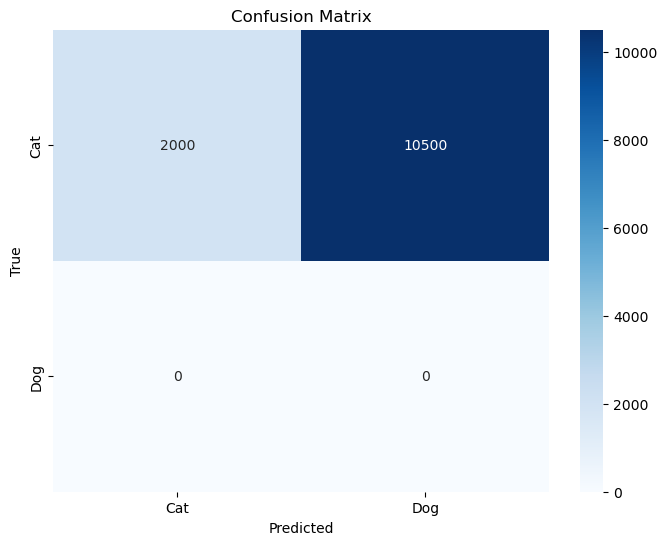

In [42]:
# Create a confusion matrix heatmap using seaborn
plt.figure(figsize=(8, 6))
class_names = ['Cat', 'Dog']  # Assuming 0 is for cat and 1 is for dog
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Lets Try to Pridict using GoogleNet model

In [ ]:
from keras.models import load_model
from keras.applications.efficientnet import preprocess_input
import numpy as np
from PIL import Image
import os
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from concurrent.futures import ThreadPoolExecutor

# Load the trained Inception model
model = load_model('/kaggle/working/Dogs_vs_cats_googlenet_mode.h5')  # Replace with the actual path to your model file

# Path to the folder containing test images
test_folder = '/kaggle/working/test/'  # Replace with the path to your test image folder

true_labels = []  # Store true labels (0 or 1)
predicted_labels = []  # Store predicted labels (0 or 1)

# Batch processing configuration
batch_size = 16  # Adjust according to your system's capacity

# Function for image processing and prediction
def process_image(img_path):
    img = Image.open(img_path)
    img = img.resize((299, 299))  # Resize to match the model's input size
    img_array = np.array(img)
    img_array = preprocess_input(img_array)  # Preprocess input image

    # Expand dimensions to create a batch-like structure
    img_array = np.expand_dims(img_array, axis=0)

    # Make predictions
    predictions = model.predict(img_array)

    true_label = int(os.path.basename(img_path).startswith('dog'))  # Assuming file names start with 'dog' or 'cat'
    predicted_label = int(predictions[0][0] > 0.5)

    return true_label, predicted_label

# Get image paths
image_paths = [os.path.join(test_folder, filename) for filename in os.listdir(test_folder)
               if filename.lower().endswith(('.jpg', '.png', '.jpeg'))]

# Process images in parallel using ThreadPoolExecutor
with ThreadPoolExecutor(max_workers=os.cpu_count()) as executor:
    results = list(executor.map(process_image, image_paths))

for true_label, predicted_label in results:
    true_labels.append(true_label)
    predicted_labels.append(predicted_label)

    print(f"True label: {true_label}, Predicted class: {predicted_label}")

1/1 [==============================] - 2s 2s/step

1/1 [==============================] - 2s 2s/step

1/1 [==============================] - 0s 41ms/step

1/1 [==============================] - 0s 49ms/step

1/1 [==============================] - 0s 36ms/step

1/1 [==============================] - 0s 54ms/step

1/1 [==============================] - 0s 40ms/step

1/1 [==============================] - 0s 45ms/step

1/1 [==============================] - 0s 39ms/step

1/1 [==============================] - 0s 51ms/step

1/1 [==============================] - 0s 46ms/step

1/1 [==============================] - 0s 55ms/step

1/1 [==============================] - 0s 50ms/step

1/1 [==============================] - 0s 48ms/step

1/1 [==============================] - 0s 42ms/step

1/1 [==============================] - 0s 42ms/step

1/1 [==============================] - 0s 57ms/step

1/1 [==============================] - 0s 44ms/step

1/1 [==============================] - 0s 40ms/ste

In [ ]:
from keras.models import load_model
from keras.applications.inception_v3 import preprocess_input
from PIL import Image
import os
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Load the fine-tuned GoogLeNet model
fine_tuned_googlenet_model = load_model('/kaggle/working/Dogs_vs_cats_googlenet_mode.h5')

def load_image_from_path(image_path):
    img = Image.open(image_path)
    img = img.resize((299, 299))  # Resize to match the model's input size
    img_array = np.array(img)
    img_array = preprocess_input(img_array)
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

mTestPath = "test/"
submission = {'id': [], 'label': []}
true_labels = []

for i, test in enumerate(os.listdir(mTestPath)):
    img = load_image_from_path(os.path.join(mTestPath, test))
    submission['id'].append(i + 1)
    
    # Assuming file names start with 'dog' or 'cat'
    true_label = int(test.startswith('dog'))
    true_labels.append(true_label)
    
    # Make predictions using the fine-tuned GoogLeNet model
    res = fine_tuned_googlenet_model.predict(img)[0][0]
    submission['label'].append(res)
    print(test, "\t", res)

import pandas as pd
submission_df = pd.DataFrame(submission)
submission_df.to_csv('Dogs_vs_cats_GoogleNet_model_1_5step.csv', index=False)

# Calculate the confusion matrix
predicted_labels = [1 if label > 0.5 else 0 for label in submission_df['label']]
cm = confusion_matrix(true_labels, predicted_labels)

# Create a confusion matrix heatmap using seaborn
plt.figure(figsize=(8, 6))
class_names = ['Cat', 'Dog']
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

1/1 [==============================] - 1s 1s/step

8290.jpg 	 0.0009326191

1/1 [==============================] - 0s 27ms/step

7495.jpg 	 1.7960398e-05

1/1 [==============================] - 0s 26ms/step

3775.jpg 	 0.99987257

1/1 [==============================] - 0s 27ms/step

6484.jpg 	 2.6998587e-05

1/1 [==============================] - 0s 27ms/step

2045.jpg 	 0.99789965

1/1 [==============================] - 0s 25ms/step

3693.jpg 	 0.99921393

1/1 [==============================] - 0s 26ms/step

12332.jpg 	 0.99987376

1/1 [==============================] - 0s 25ms/step

7815.jpg 	 0.99279684

1/1 [==============================] - 0s 26ms/step

1034.jpg 	 0.9978077

1/1 [==============================] - 0s 27ms/step

3357.jpg 	 0.9999685

1/1 [==============================] - 0s 30ms/step

4744.jpg 	 0.99990594

1/1 [==============================] - 0s 27ms/step

8855.jpg 	 0.9993462

1/1 [==============================] - 0s 26ms/step

6934.jpg 	 0.9999069

1/1 [====

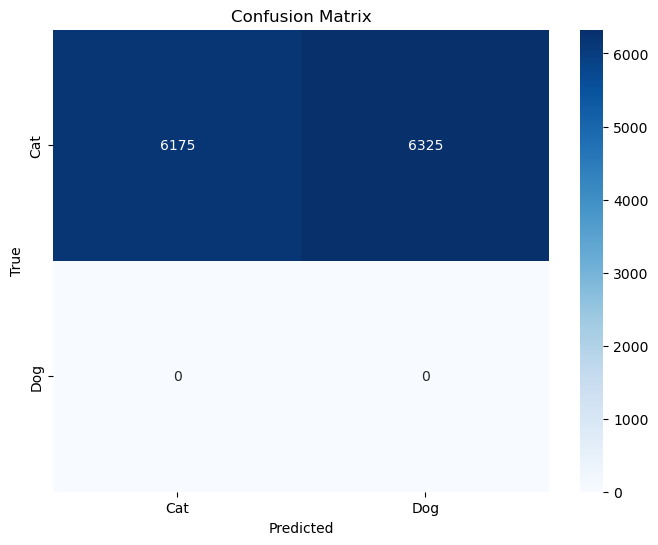

In [32]:
# Create a confusion matrix heatmap using seaborn
plt.figure(figsize=(8, 6))
class_names = ['Cat', 'Dog']
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [1]:
# I have executed all above models with basic method and then tried again by fine tuning it.
# As per my observation Inception, EfficentNet and GoogleNet perform very well interms of accuracy and loss fucntion.
# In this example i have used Inception and GoogleNet's Fine Tuned models and got better results in each epoc.
# I have taken max 5 epoc for each pre-trained model (As GPU limit is exhusted) and Confusion matrix is not satisfied to me.
# I belive that if i try for some more epoc i get some better results.
# With this Assignment i understood how to play with pre-trained models and different model architechures.